# Wicklow isolates snipgenie analysis

* https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000388?crawler=true

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import rpy2

## Run workflow 

Add outgroup samples from Northern Ireland..

In [ ]:
reload(app)
reload(tools)
args = {'threads':12, 'outdir': '/storage/btbgenie/wicklow_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Wicklow/'],
         'omit_samples':['161-MBovis','182-MBovis'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True, 'get_stats':False,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
#snprecs, smat = tools.fasta_alignment_from_vcf('/storage/btbgenie/wicklow_results/filtered.vcf.gz', omit=['161-MBovis'])

In [2]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
spo=spo.fillna('')

In [3]:
%load_ext rpy2.ipython

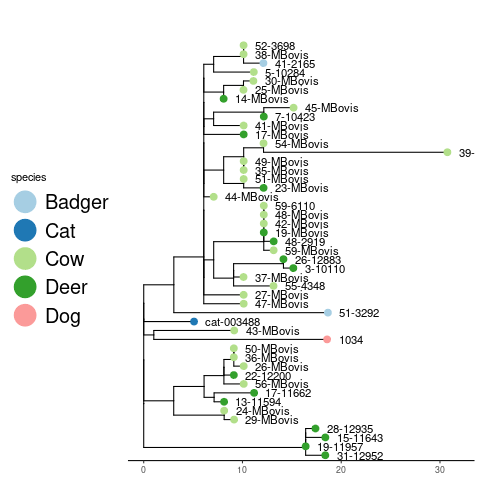

In [31]:
%%R
source('drawtrees.R')
meta <- read.table('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv',sep=',',
                      header=TRUE,row.names=1)
meta[is.na(meta)] <- "-"
meta[] <- lapply(meta, as.character)
mltree <- read.tree('/storage/btbgenie/wicklow_results/tree.newick')
mltree <- drop.tip(mltree,c('182-MBovis','ref'))
#mltree <- root(mltree, outgroup='cat-003488')
options(repr.plot.width=20, repr.plot.height=10)
ggplottree(mltree, meta, 'species', layout='rect', cmap='Paired', tiplabel=TRUE)


## snp distance matrix

cat-003488     0
44-MBovis     12
13-11594      13
14-MBovis     13
24-MBovis     13
36-MBovis     14
43-MBovis     14
22-12200      14
29-MBovis     14
50-MBovis     14
Name: cat-003488, dtype: int64


/tmp/ipykernel_3310333/2257668748.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sm=sm.drop('182-MBovis').drop('182-MBovis',1)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


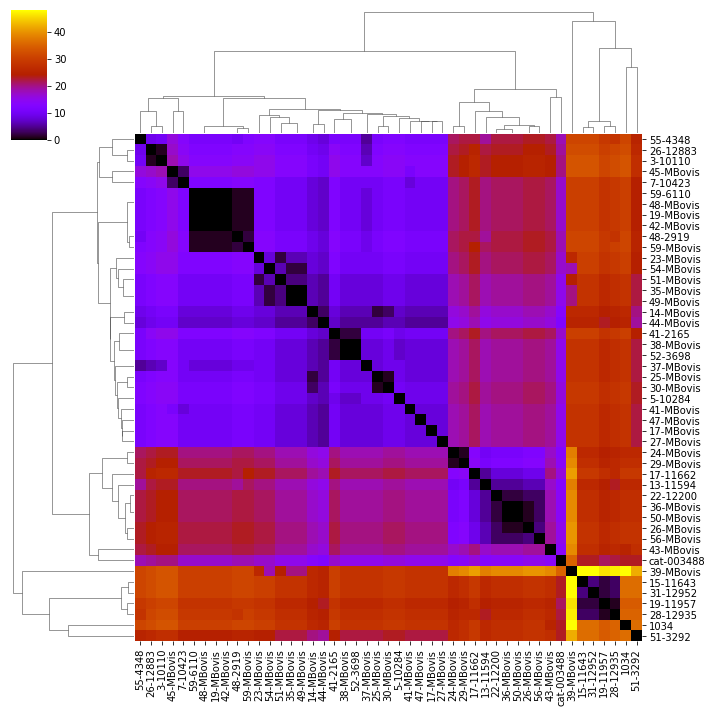

In [35]:
sm = pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv',index_col=0)
print (sm.loc['cat-003488'].sort_values()[:10])
sm=sm.drop('182-MBovis').drop('182-MBovis',1)
import seaborn as sns
sns.clustermap(sm, cmap='gnuplot',xticklabels=True,yticklabels=True)

In [14]:
csq = app.read_csq_file('/storage/btbgenie/wicklow_results/csq.tsv')
snpmat = app.get_aa_snp_matrix(csq)

In [34]:
#snps unique to a sample
name = 'cat-003488'
#name = '1034'

def get_unique_snps(name, df):
    """Get snps unique to a sample from a snp matrix"""
    
    insamp = df[name]
    other = df.loc[:, df.columns != name]
    u = other[other.sum(1)==0]
    return insamp.loc[u.index]

get_unique_snps(name, snpmat)

start    gene            aa         snp_type  
1461929  rfe             393R>393C  missense      1
2753251  gdh             528A>528G  missense      1
2967659  BQ2027_MB2708c  151H>151R  missense      1
3057726  BQ2027_MB2810   552V>552E  missense      1
3355243  BQ2027_MB3060c  217S       synonymous    1
Name: cat-003488, dtype: int64

## RD analysis

In [ ]:
from snpgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/wicklow_rd',threads=12)

In [ ]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
plotting.heatmap(X.set_index('ident',append=True), cmap='cubehelix',h=8)
#plt.savefig('rd_wicklow.png')

# vs JC pipeline results
## Compare sites matrix

In [ ]:
smat = pd.read_csv('/storage/btbgenie/wicklow_results/core.txt',sep=' ',index_col=0)
smat.index
joe_sites = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/FASTA/fastaPositions_Prox-10_18-12-2019.txt')
#print (joe_sites)
plt.figure(figsize=(6,6))
import matplotlib_venn
#mpl.rc('text', usetex=True)
mpl.rc('font',size=14)
sets=[set(joe_sites.Position),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Joe','snpgenie'],set_colors=['#4d88ff','#ff3333'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_joe.png',dpi=100)

## identify non overlapping sites

In [55]:
df = app.read_csq_file('/storage/btbgenie/wicklow_results/csq.tsv')
x = df.set_index(['start','gene','aa','sample'])['nuc'].unstack('sample')

len(x), len(smat)

(524, 544)

In [ ]:
n=list(set(joe_sites.Position) - set(smat.index))
csqmat = pd.read_csv('../test_results/csq.matrix')#.set_index(['gene','aa'])
x[x.start.isin(n)]

In [59]:
#frequencies of sites
sitefreqs = (csqmat.sum(1)/len(csqmat.columns)).sort_values(ascending=False)
sitefreqs.value_counts()

0.0625    1798
0.1875     881
0.1250     403
0.7500     153
0.6875      77
0.8750      64
0.2500      36
0.4375      21
0.5000      10
0.6250       6
0.3750       3
0.5625       3
0.3125       2
dtype: int64

In [6]:
#print(W.fastq_table)
meta['name'] = meta.Forward.apply(lambda x: x.split('.')[0])
print(meta.loc[0])
s = pd.merge(W.fastq_table,meta,on='name')
labelmap = dict(zip(s['sample'],s.County))
#print (labelmap)


SeqID                                        1034
Forward           1034_S91_L001-4_R1_001.fastq.gz
Reverse           1034_S91_L001-4_R2_001.fastq.gz
NumberMapped                               902962
MappingProp                              0.999386
SequencingDate                           24-09-19
County                                   Monaghan
VCF                                 1034_1.vcf.gz
Coverage                                 0.900721
AverageDepth                              27.7094
Aliquot                               TB19-001034
Species                                       NaN
Date                                          NaN
name                       1034_S91_L001-4_R1_001
Name: 0, dtype: object


In [ ]:
reload(trees)
mytree,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants')# ref='ref',labelmap=labelmap)
mytree.render("%%inline",tree_style=ts)

## Compare trees

In [ ]:
reload(trees)
t = trees.create_tree('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/mlTree_WICKLOW_18-12-2019.tree')#, labelmap)
t.render("%%inline")

## bionumerics comparison

In [76]:
reload(app)
reload(tools)
#run only samples to compare to bionumerics tree
names = ['26-12883','55-4348','48-2919','59-6110','41-2165','52-3698','51-3292','13-11594',
         '17-11662','19-11957','28-12935','15-11643','31-12952','22-12200']

path='/storage/btbgenie/wicklow_results/mapped/'
bam_files = app.get_files_from_paths(path, '*.bam', filter_list=names)
#print (bam_files)
app.run_bamfiles(bam_files, app.mbovis_genome,outdir='wicklow_compare',threads=10,custom_filters=True,mask=None)

wicklow_compare/raw.bcf already exists
calling snps..
bcftools call -V indels --ploidy 1 -m -v -o wicklow_compare/calls.vcf wicklow_compare/raw.bcf
bcftools reheader --samples wicklow_compare/samples.txt -o /tmp/calls.vcf wicklow_compare/calls.vcf
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4 && MQ>30" -o wicklow_compare/filtered.vcf.gz -O z wicklow_compare/calls.vcf
proximity filter found 382/405 sites
took 13.0 seconds
found 83 sites
0 sites with at least one missing sample
299 uninformative sites
raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 28397685 -x 78313451 -n variants -w /home/damien/gitprojects/snipgenie/notebooks/wicklow_compare -s wicklow_compare/core.fa


In [71]:
vdf=tools.vcf_to_dataframe('wicklow_compare/filtered.vcf.gz')
len(vdf.mut.unique())

490

In [9]:
import toytree 
import toyplot 
tre1 = toytree.tree('wicklow_compare/RAxML_bipartitions.variants')
#tre1 = toytree.tree('wicklow_compare/fasttree.newick')
tre1=tre1.drop_tips(wildcard="ref")
tre2 = toytree.tree('bionumerics_wicklow.newick')